# Parameter identification interface
### User-interface to perform parameter identification of bioscrape/SBML models

* Simple functions to import models/data 
* Use the fast deterministic and stochastic simulators available within bioscrape
* (Optionally) Specify parameter priors, desired likelihood/cost functions 
* Create your own likelihood functions interface

## Loglikelihood Functions
Bioscrape comes with a number of built in log-likelihood functions for deterministic or stochastic parameter inference. These functions are detailed in the following notebook. First, a simple model is made to test the functions:

$\emptyset \xrightarrow[]{k_1} X \; \; \; \; X \xrightarrow[]{d_1} \emptyset$

A set of N trajectories is then generated from this model, from either the same or different initial conditions, across the same or different time-windows. Gaussian noise is then added to all the samples. Finally, bioscrape inference functions are used to run MCMC to get parameter distributions.

In [18]:
%matplotlib inline
import bioscrape as bs
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model

import numpy as np
import pylab as plt

# Import bioscrape XML / bioscrape model object M / SBML file
# M  = bs.types.read_model_from_sbml(filename)
# M = Model('models/pid_model.xml')

# Or...Create a Model using the bioscrape API
species = ['X']
reactions = [(['X'], [], 'massaction', {'k':'d1'}), ([], ['X'], 'massaction', {'k':'k1'})]
k1 = 10.0
d1 = .2
params = [('k1', k1), ('d1', d1)]
initial_condition = {'X':0}
M = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)

# Import data from CSV
# data = import_timeseries('test_data.csv', time_column = 2, value_column = 4, properties = {3 : 51})

M.py_initialize()

N = 10 #Number of trajectories

timepoints = np.array([2.0,5.0,10.0,20.0])
nS = len(timepoints) #number of time samples
noise_std = 0.8 #Standar deviation of the guassian noise added onto the measurements


#Generate Trajectories
R = [] #Results as Pandas Dataframes
data = [] #Results will become a numpy array
MultipleInitialConditions = True #Different initial condi tions for each trajectory? # No need to specify here for experimental data, can be detected automatically

X0_list = [] #multiple initial conditions will be saved for inference
for n in range(N):
    if MultipleInitialConditions:
        initial_condition = {'X': np.random.randint(0, 100)}
        X0_list.append(initial_condition)
        
    if MultipleTimepoints:
        timepoints = np.linspace(np.random.randint(0, 10, 1), np.random.randint(10, 100, 1), num = 50).flatten()
        timepoint_list.append(timepoints)
    
    M.set_species(initial_condition)
    r = py_simulate_model(timepoints, Model = M, stochastic = False)
    init_save = r['X'][0]
    R.append(r)
    r['X'] = r['X'].to_numpy() + np.random.normal(loc = 0, scale = noise_std, size = nT)
    r['X'][0] = init_save
    data.append(r)

M_original = Model(species = species, reactions = reactions, parameters = params, 
          initial_condition_dict = initial_condition)
M_original.write_bioscrape_xml('models/toy_model.xml')


In [19]:
r['X'][0]

64.0

### To run the MCMC algorithm to identify parameters from the data, the following code can be used.

Successfully completed MCMC parameter identification procedure. Parameter distribution data written to mcmc_results.csv file


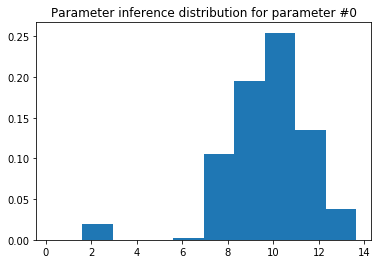

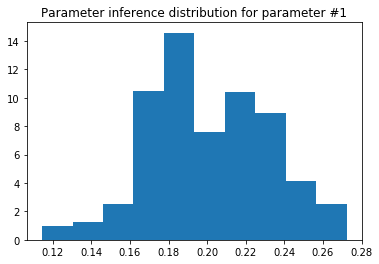

In [20]:
# Run parameter identification procedure using Python emcee -
from bioscrape.pid_interfaces import *
from bioscrape.emcee_interface import *

pid = initialize_mcmc()
pid.exp_data = data
pid.time_column = ['time']
pid.measurements = ['X']
pid.M = M
pid.prior = {'k1' : ['uniform', 0.1, 1000],'d1' : ['uniform', 1e-2, 10]}
pid.params_to_estimate = ['k1', 'd1']
pid.type = 'deterministic'
pid.timepoints = timepoint_list
pid.initial_conditions = X0_list
pid.nsamples = 500
pid.nsteps = 200
pid.nwalkers = 100
pid.init_seed = 0.15
fitted_model, params = pid.run_mcmc(plot_show = True, progress = True, debug = False)

### Plot all data

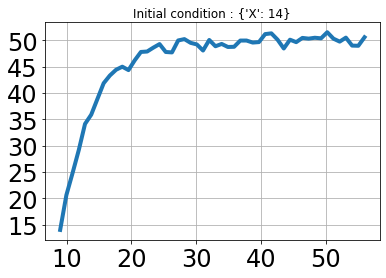

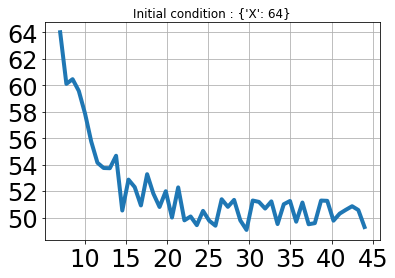

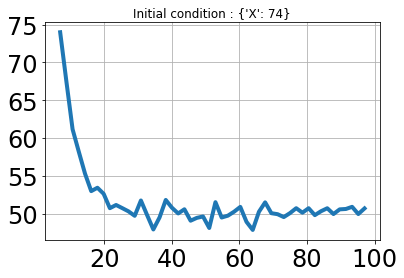

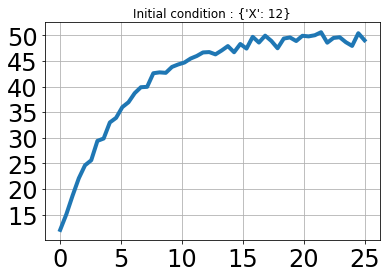

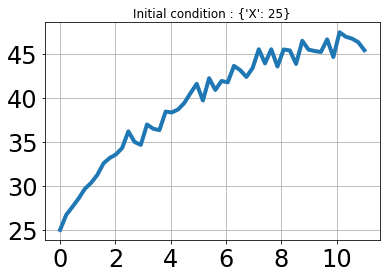

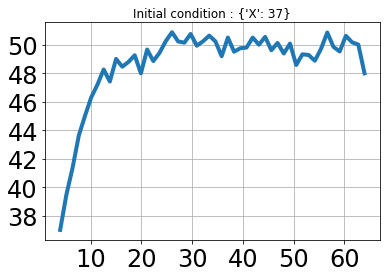

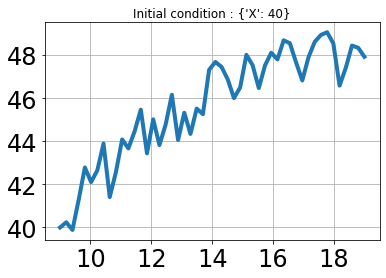

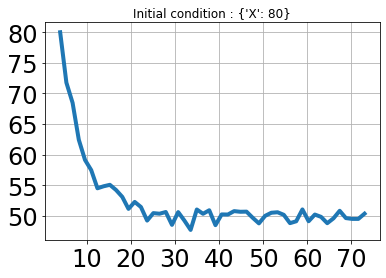

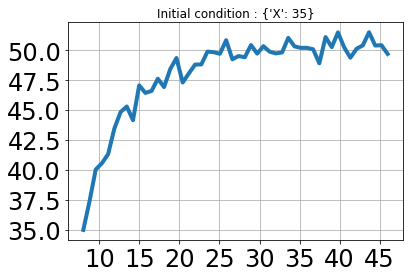

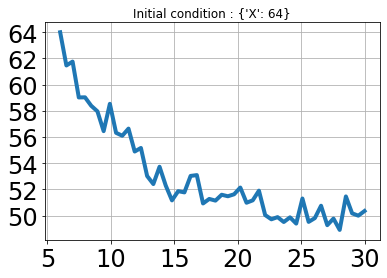

In [28]:

for i in range(len(timepoint_list)):
    plt.figure()
    M_original.set_species(X0_list[i])
    fitted_model.set_species(X0_list[i])
    sim_x = py_simulate_model(timepoints, Model = M_original, stochastic = False)
    sim_x_inf = py_simulate_model(timepoints, Model = fitted_model, stochastic = False)
    plt.plot(timepoint_list[i], data[i]['X'], linewidth = 4)
#     plt.plot(timepoint_list[i], sim_x['X'], 'r--', label = 'Original model')
#     plt.plot(timepoint_list[i], sim_x_inf['X'], 'k', label = 'Identified model')
    plt.title('Initial condition : {0}'.format(X0_list[i]))
    plt.xticks(fontsize = 24)
    plt.yticks(fontsize = 24)
    plt.grid(True, which = 'both')
    plt.savefig('time'+str(i)+'.svg')
#     plt.legend()

In [4]:
import pandas as pd
# Write noisy data to csv
# df = pd.concat(R)
file_name = 'test_data.csv'
R[-1].to_csv(file_name, sep='\t', header = True)

In [5]:
M_original.write_bioscrape_xml('models/toy_model.xml')


In [6]:
fitted_model.get_parameter_values()

array([0.19297741, 9.79023625])